In [1]:
import sys
sys.path.append('..')
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from project_specific_utils import read_pressure
from project_specific_utils.read_pressure import PIVdata
from scipy import interpolate
from matplotlib import mlab

In [2]:
# which_sets = PIVdata.all_tests()

# with h5py.File('../data/raw_pressure.h5','r') as hf:
#     print(hf.keys())
#     dt = np.squeeze(hf.get('dt'))
#     static_p = np.squeeze(hf.get('static_p'))
#     esp = np.array(hf.get('esp')).T/static_p
#     r = np.array(hf.get('r')).T
#     theta = np.array(hf.get('theta')).T

with h5py.File('../data/raw_pressure_long.h5','r') as hf:
    print(hf.keys())
    fs = np.squeeze(hf.get('fs'))
    static_p = np.squeeze(hf.get('static_p'))
    esp = np.array(hf.get('esp')).T
    r = np.array(hf.get('r')).T
    theta = np.array(hf.get('theta')).T

x=(np.cos(theta*np.pi/180).T)*r
y=(np.sin(theta*np.pi/180).T)*r 
x = x.flatten()
y = y.flatten()

<KeysViewHDF5 ['esp', 'fs', 'r', 'static_p', 'theta']>


In [3]:
## Parameters
nfft_psd = 2**14
overlap = nfft_psd/2
# sampling_freq = 720
sampling_freq = fs
# num_of_tests = len(which_sets)
D = 196.5 #mm
Uinf = 15 #m/s


In [4]:
# esp_allt = np.concatenate(esp[which_sets,:,:],axis=1)
esp_allt = esp
pmean = np.mean(esp_allt,axis=1).reshape(8,8)
prms = np.std(esp_allt,axis=1)

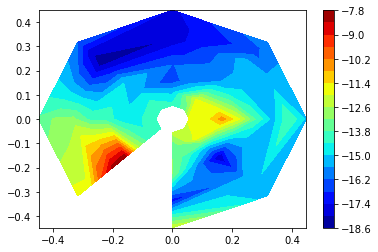

In [5]:
plt.figure()
# plt.contourf(x.reshape(8,8),y.reshape(8,8),pmean,levels=10,cmap='jet')
# plt.contourf(x.reshape(8,8)[:6,:],y.reshape(8,8)[:6,:],esp_allt[:,4].reshape(8,8)[:6,:],levels=20,cmap='jet')
plt.contourf(x.reshape(8,8),y.reshape(8,8),esp_allt[:,4].reshape(8,8),levels=20,cmap='jet')
plt.colorbar()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[[ 0.0004655  -0.00062117]]


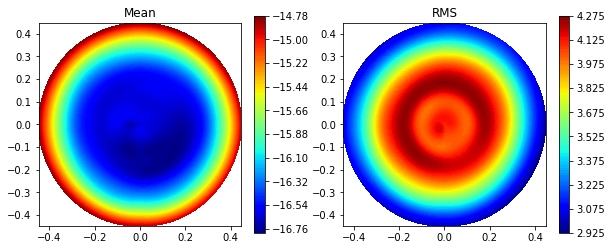

In [6]:
print(read_pressure.cop(pmean.reshape((64,1))))
x_interp,y_interp,pmean_interp = read_pressure.interp(pmean,nint=15,filter=False)
_,_,prms_interp = read_pressure.interp(prms,nint=15,filter=False)

plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im1 = ax1.contourf(x_interp,y_interp,pmean_interp,levels=100,cmap='jet')
ax1.set_aspect('equal')
ax1.set_title('Mean')
plt.colorbar(im1,ax=ax1)

ax2 = plt.subplot(122)
im1 = ax2.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax2.set_aspect('equal')
ax2.set_title('RMS')
plt.colorbar(im1,ax=ax2)

plt.show()


## Convert to Cartesian

In [7]:
rmax = r[0,-1]
rgrid = np.linspace(-rmax,rmax,150)
print(rgrid[:3])
# Create a meshgrid using numpy.meshgrid
x_mesh, y_mesh = np.meshgrid(rgrid,rgrid)

# Prepare grid points for interpolation
grid_points = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))

# Combine the two meshgrids to get the desired array
mesh = np.stack((x_mesh, y_mesh), axis=2)
mesh_flatten = mesh.reshape((-1,2))

[-0.44783714 -0.44182591 -0.43581467]


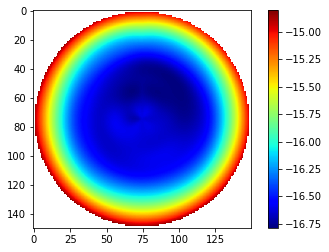

In [8]:
pmean_cartesian = interpolate.griddata((x_interp.flatten(), y_interp.flatten()), pmean_interp.flatten(), mesh_flatten, method='linear')

outside = (x_mesh**2 + y_mesh**2)**0.5 > max(y)
pmean_cartesian.reshape((150,150))[outside] = np.nan
plt.figure()
plt.imshow(pmean_cartesian.reshape((150,150)),'jet')
plt.colorbar()

# Decompose

In [9]:
from MD_AE_tools.mode_decomposition import POD
from numpy import einsum

In [10]:
r1 = [0]
ri = np.zeros((1,8))
dr = r[0,1]-r[0,0]
dth = 2*np.pi/8
r1.extend(list(np.squeeze(r))[:-1])
r2 = 0.5 * (np.squeeze(r) + np.array(r1))
dA_weight = r2*dr*dth
dA_weight = np.tile(dA_weight,8)

In [11]:
# data = np.concatenate(esp_allt,axis=1)
# data.shape
# # pod_data = POD(data,weight=dA_weight)
pod_data = POD(esp_allt)
# pod_data = POD(esp[0,:,:])
modes,lam = pod_data.get_modes
a = pod_data.get_time_coefficient

Calculating POD ...
Use classic POD, Nx <= Nt.


/home/ym917/Codes/MD-CNN-AE/notebook_visualise/../MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


POD done.
Returning temporal coefficients for classic POD.


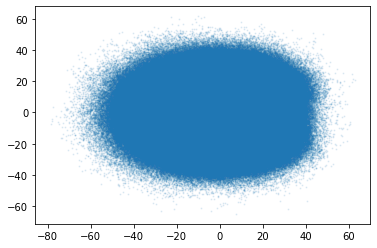

In [12]:
plt.figure()
plt.scatter(a[:,0],a[:,1],1,alpha=0.1)

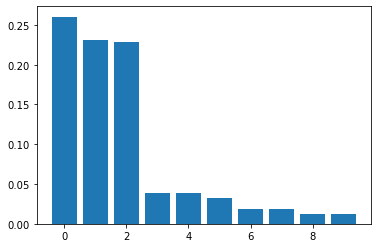

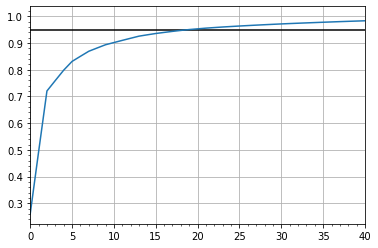

20 modes for 95% energy


In [21]:
plt.figure()
plt.bar(np.arange(10),lam[:10]/np.sum(lam))

plt.figure()
cumulative_energy = np.cumsum(lam)/np.sum(lam)
plt.plot(cumulative_energy)
plt.hlines(0.95,0,60,'k')
plt.minorticks_on()
plt.grid('both')
plt.xlim([0,40])

plt.show()
cumulative_energy[19]
print('20 modes for 95% energy')

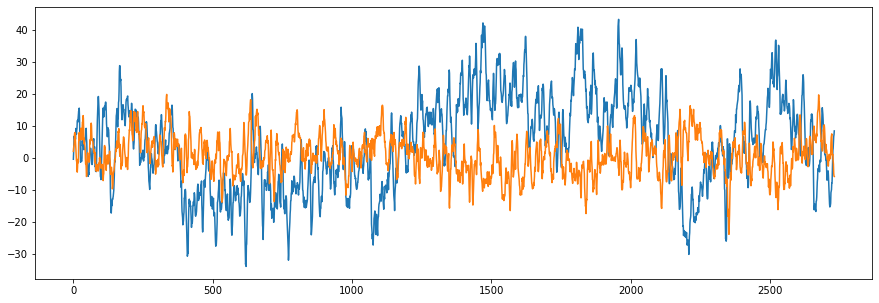

In [14]:
plt.figure(figsize=(15,5))
plt.plot(a[:2732,2])
plt.plot(a[:2732,3])
# plt.plot(a[:,3])

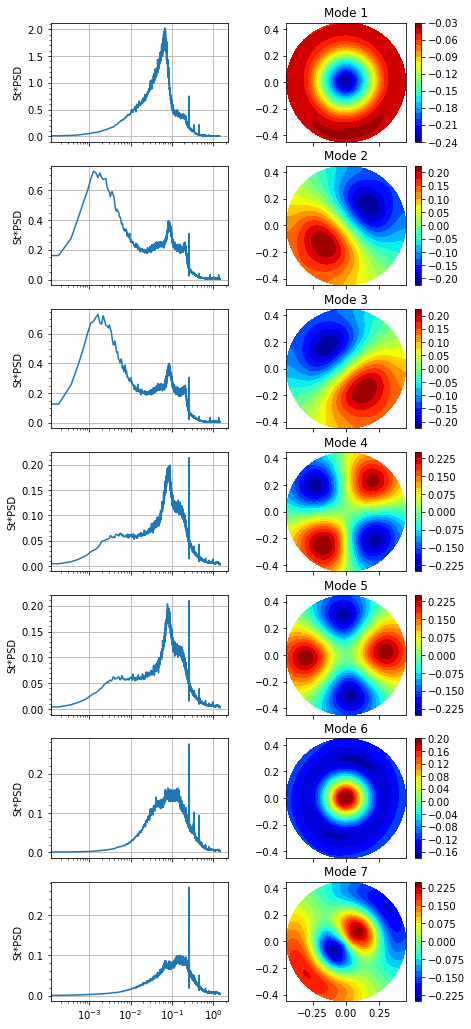

In [15]:

fig,axes = plt.subplots(7,2,sharex='col',figsize=(7,18))

for m in range(7):

    

    x_interp,y_interp,interpolated_values = read_pressure.interp(modes[:,m])
    im = axes[m,1].contourf(x_interp,y_interp,interpolated_values,levels=20,cmap='jet')
    axes[m,1].set(aspect='equal',title=f'Mode {m+1}')
    plt.colorbar(im,ax=axes[m,1])

    # spp,freqs = mlab.psd(a[:2732,m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    spp,freqs = mlab.psd(a[:,m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    st = (D/1000/Uinf)*freqs
    # for j in range(1,num_of_tests):
    #     spp1,_ = mlab.psd(a[2732*j:2732*(j+1),m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    #     spp = spp + spp1
    # spp = spp/num_of_tests
    axes[m,0].semilogx(st,st*spp,label=str(m+1))
    axes[m,0].set(ylabel='St*PSD')
    axes[m,0].minorticks_on()
    axes[m,0].grid('both')




plt.show()

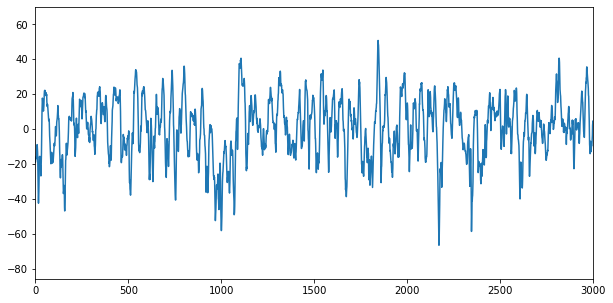

In [21]:
plt.figure(figsize=(10,5))
plt.plot(a[:,0])
plt.xlim([0,3000])
plt.show()

# CoP

In [94]:
copall = read_pressure.cop(esp_allt)
rx = copall[:,0]
ry = copall[:,1]

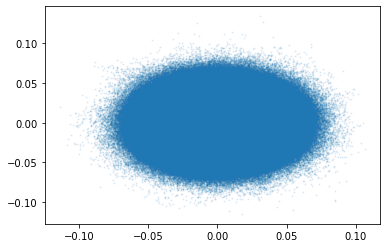

In [95]:
plt.figure()
plt.scatter(rx,ry,1,alpha=0.1)

In [96]:
rcop = (rx**2+ry**2)**0.5
thcop = np.arctan(ry/rx)

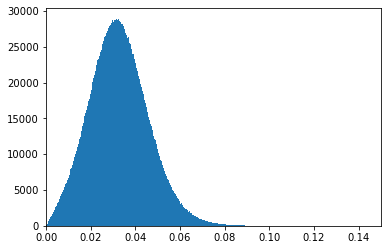

In [97]:
figure, ax1 = plt.subplots(1)
cnts, bins = np.histogram(rcop, bins='auto')
ax1.bar(bins[:-1] + np.diff(bins) / 2, cnts, np.diff(bins))
ax1.set_xlim([0,0.15])
plt.show()

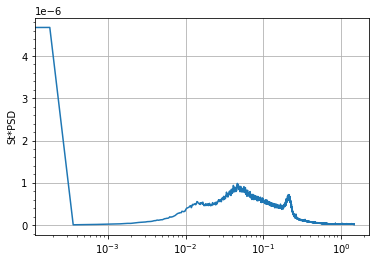

In [98]:
from matplotlib import mlab
plt.figure()
ax = plt.subplot(111)
spp,freqs = mlab.psd(rcop,Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
# for j in range(1,num_of_tests):
#     spp1,_ = mlab.psd(rcop[2732*j:2732*(j+1)],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
#     spp = spp + spp1
# spp = spp/num_of_tests
ax.semilogx(st,st*spp)
ax.set(ylabel='St*PSD')
ax.minorticks_on()
ax.grid('both')

plt.show()

In [99]:
f_rotation = 0.002/((D/1000/Uinf))
period_rotation = 1/f_rotation
print('Period for the VLF mode (t): ',period_rotation)

Period for the VLF mode (t):  6.55
